# Preprocessing for ECG Classification

# Data

This analysis used segmented time-series data obtained from https://www.kaggle.com/shayanfazeli/heartbeat
Data Source: Physionet's MIT-BIH Arrhythmia Dataset

- Time series are zero-padded, 187-element vectors containing the ECG lead II signal for one heartbeat.
- Labels [0, ..., 4] represent normal heartbeats and 4 classes of arrhythmia ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- 'N - Normal Beat', 'S - Supraventricular premature or ectopic beat', 'V - Premature ventricular contraction',  'F - Fusion of ventricular and normal beat',  'Q - Unclassified beat'
- Number of Samples: 109446
- The class distribution is highly skewed. N = [90589, 2779, 7236, 803, 8039].
- In PreprocessECG.ipynb I take 100 examples from each class for the test set, and use the remainder for the training set. Under-represented classes are - upsampled to balance the class ratios for training.

Randomly sample 100 of each class of time-series for the test set. This is just over 10% of the samples in the smallest class.
Remaining data is balanced for the training set by upsampling under-represented classes.

In [12]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
CSV_1 = './Data/mitbih_train.csv'
CSV_2 = './Data/mitbih_test.csv'

TRAIN_SET = './Data/train_set.pickle'
TEST_SET = './Data/test_set.pickle'

raw_1 = pd.read_csv(CSV_1, header=None)
raw_2 = pd.read_csv(CSV_2, header=None)
raw = pd.concat([raw_1, raw_2], axis=0)

shuffled = raw.sample(frac=1, axis=0)
del raw
del raw_1
del raw_2

values = shuffled.values
x = values[:, :-1]
y = values[:, -1].astype(int)
del values
del shuffled

In [3]:
x

array([[0.95184135, 0.71954674, 0.17563739, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.63905323, 0.21005917, ..., 0.        , 0.        ,
        0.        ],
       [0.96546549, 1.        , 0.51651651, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.94609165, 0.90296495, 0.45552561, ..., 0.        , 0.        ,
        0.        ],
       [0.89583331, 0.9537037 , 0.38657406, ..., 0.        , 0.        ,
        0.        ],
       [0.86036962, 0.56057495, 0.16221766, ..., 0.        , 0.        ,
        0.        ]])

In [4]:
x.shape

(109446, 187)

In [5]:
y

array([0, 0, 1, ..., 0, 1, 0])

In [6]:
y.shape

(109446,)

Let's visualize signals from each type of Arrhythmia

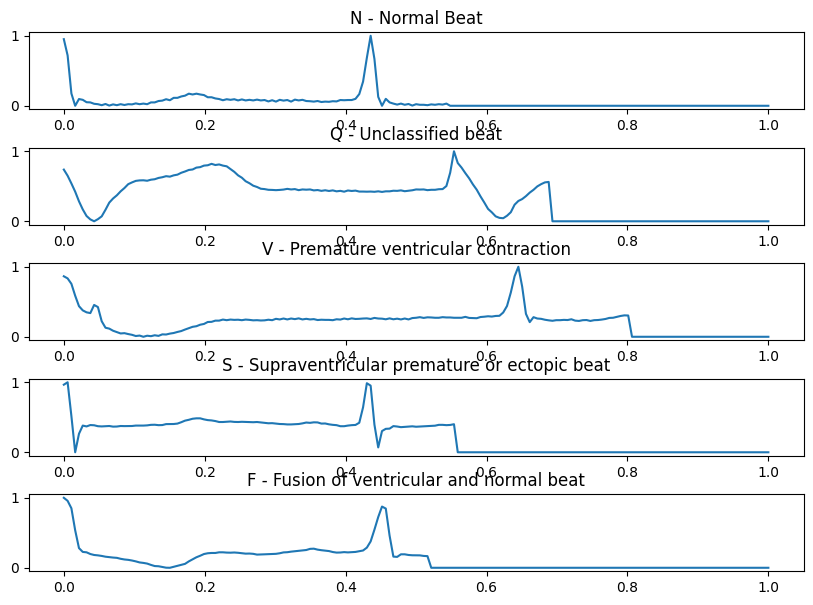

In [16]:
# get the indexes of all labels
n_indexes = np.where(y == 0)[0] #Normal Beat
q_indexes = np.where(y == 4)[0] #Unclassified beat
v_indexes = np.where(y == 2)[0] #Premature ventricular contraction
s_indexes = np.where(y == 1)[0] #Supraventricular premature or ectopic beat
f_indexes = np.where(y == 3)[0] #Fusion of ventricular and normal beat

# sample one observation per class by indexing the train_labels
n_index = n_indexes[0]
q_index = q_indexes[0]
v_index = v_indexes[0]
s_index = s_indexes[0]
f_index = f_indexes[0]

def generate_subplot(figure, obs, gridspec, row, col, title):
    axis = figure.add_subplot(gridspec[row, col])
    axis.plot(np.linspace(0, 1, obs.shape[0]), obs)
    axis.set_title(title)

# Plot samples
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
gs = fig.add_gridspec(5, 1)

generate_subplot(fig, x[n_index], gs, 0, 0, 'N - Normal Beat')
generate_subplot(fig, x[q_index], gs, 1, 0, 'Q - Unclassified beat')
generate_subplot(fig, x[v_index], gs, 2, 0, 'V - Premature ventricular contraction')
generate_subplot(fig, x[s_index], gs, 3, 0, 'S - Supraventricular premature or ectopic beat')
generate_subplot(fig, x[f_index], gs, 4, 0, 'F - Fusion of ventricular and normal beat')

plt.show()

# Percentage Distribution of Heartbeat Classes

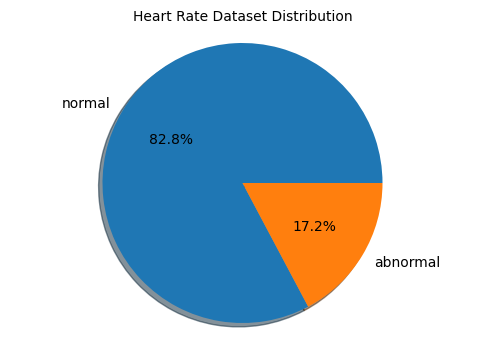

In [22]:
labels = ['normal', 'abnormal']
sizes = [90589, 18857]

# Plotting the pie chart with the specified labels and sizes
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, shadow=True)
ax1.axis('equal')
fig1.set_size_inches(6,4)
ax1.set_title("Heart Rate Dataset Distribution", fontsize=10)
plt.show()

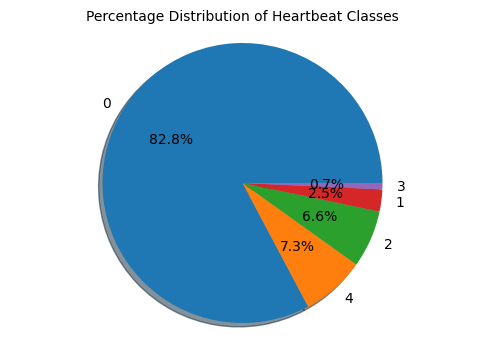

In [24]:
y_series = pd.Series(y)

# Calculate the counts of each unique label in descending order
observation_counts = y_series.value_counts()

# Extract the labels in descending order of their frequency
labels_descending = observation_counts.index.to_numpy()

fig1, ax1 = plt.subplots()
ax1.pie(observation_counts, labels=labels_descending, autopct='%1.1f%%', startangle=0, shadow=True)
ax1.axis('equal')
fig1.set_size_inches(6,4)
ax1.set_title("Percentage Distribution of Heartbeat Classes", fontsize=10)
plt.show()

In [20]:
print(observation_counts)

0    90589
4     8039
2     7236
1     2779
3      803
Name: count, dtype: int64


In [7]:
TEST_CLASS_SIZE = 100

class_x = []
class_count = []

for label in range(5):
    x_i = x[y == label]
    
    # Take the first TEST_CLASS_SIZE elements for the test set
    if label == 0:
        x_test = x_i[:TEST_CLASS_SIZE, :]
        y_test = np.zeros((TEST_CLASS_SIZE)).astype(int)
    else:
        x_test = np.concatenate((x_test, x_i[:TEST_CLASS_SIZE, :]), axis=0)
        y_test = np.concatenate((y_test, np.zeros((TEST_CLASS_SIZE)).astype(int) + label))
        
    # Use the remainder of the elements for the training set
    x_i = x_i[TEST_CLASS_SIZE:, :]
    class_x.append(x_i)
    class_count.append(len(x_i))

# Compute the multiple of class elements needed to balance the classes
counts = (np.floor(max(class_count) / np.array(class_count))).astype(int)
print('Multiples:', counts)

# Append repeated values for under-represented classes
for label in range(5):
    count = counts[label]
    if label == 0:
        x_bal = class_x[label]
        y_bal = np.zeros((class_count[label])).astype(int)
        count -= 1

    for j in range(count):
        x_bal = np.concatenate((x_bal, class_x[label]), axis=0)
        y_bal = np.concatenate((y_bal, np.zeros((class_count[label])).astype(int) + label))

print('Training set shapes:', np.shape(x_bal), np.shape(y_bal))
print('Test set shapes:', np.shape(x_test), np.shape(y_test))

with open(TEST_SET, 'wb') as file:
    pickle.dump({'x': x_test, 'y': y_test}, file)

with open(TRAIN_SET, 'wb') as file:
    pickle.dump({'x': x_bal, 'y': y_bal}, file)

Multiples: [  1  33  12 128  11]
Training set shapes: (441841, 187) (441841,)
Test set shapes: (500, 187) (500,)
